/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,R2,Mse,Precision,Recall,F1
1,565.884800,452.151642,0.542396,452.151642,0.699599,1.000000,0.823252
2,244.481300,292.599060,0.703872,292.599060,0.699599,1.000000,0.823252
3,120.701600,185.155060,0.812612,185.155060,0.699599,1.000000,0.823252
4,107.437600,134.546173,0.863831,134.546173,0.699599,1.000000,0.823252
5,72.886600,97.705864,0.901116,97.705864,0.699599,1.000000,0.823252
6,84.252300,111.814713,0.886837,111.814713,0.699599,1.000000,0.823252
7,32.867700,57.477268,0.941830,57.477268,0.699599,1.000000,0.823252
8,19.973200,45.623619,0.953826,45.623619,0.764404,0.960573,0.851334
9,17.473500,36.890781,0.962664,36.890781,0.732626,0.989964,0.842073
10,13.996600,35.578705,0.963992,35.578705,0.789192,0.952688,0.863267


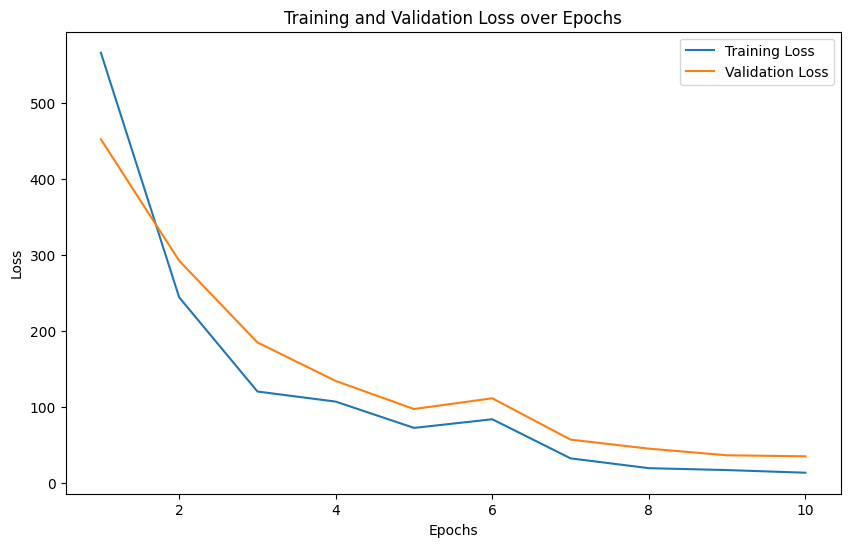

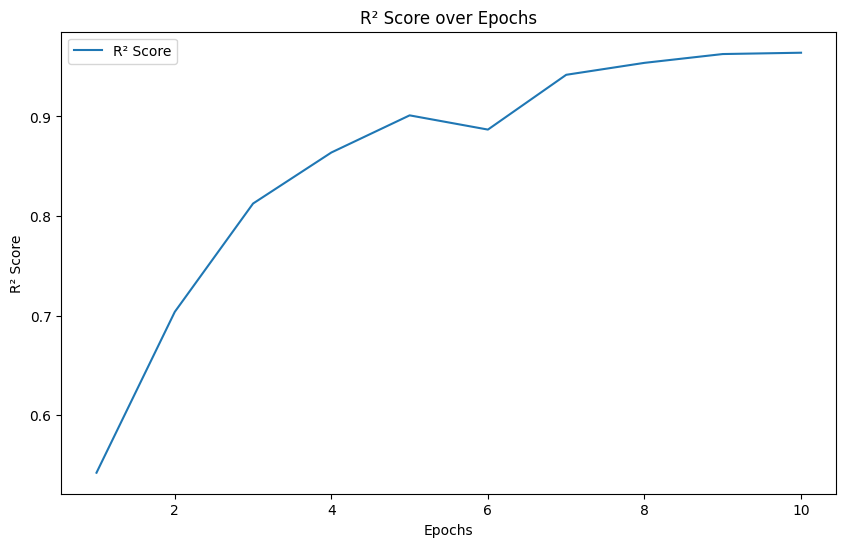

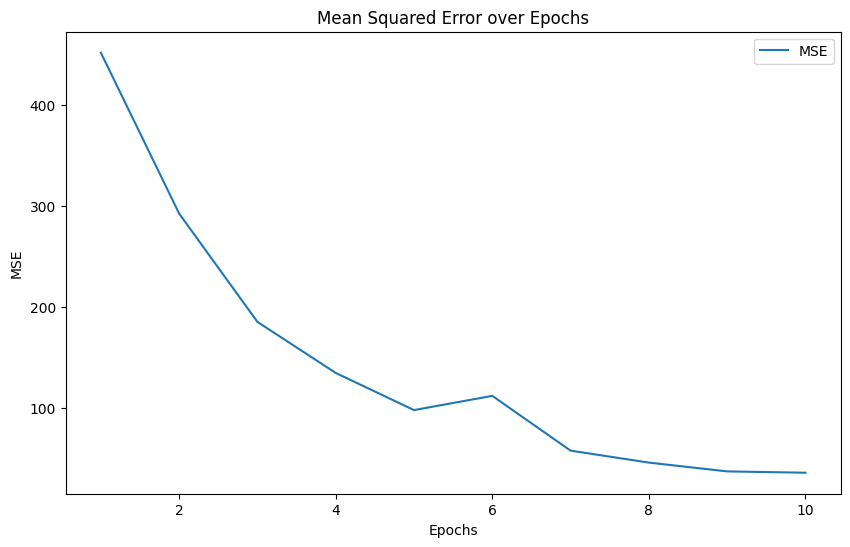

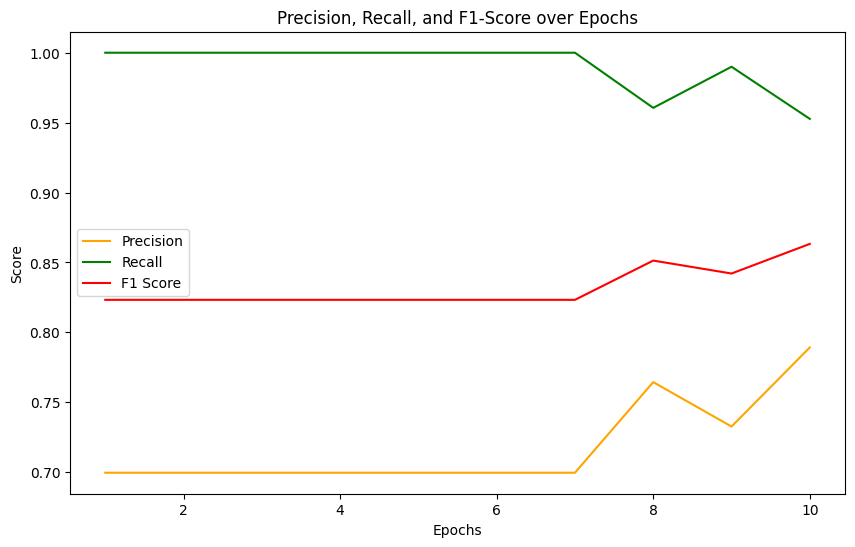

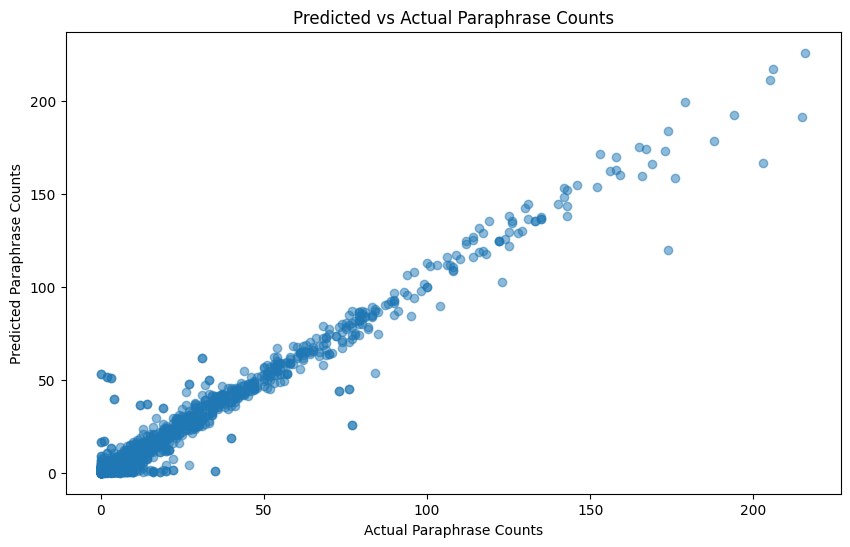

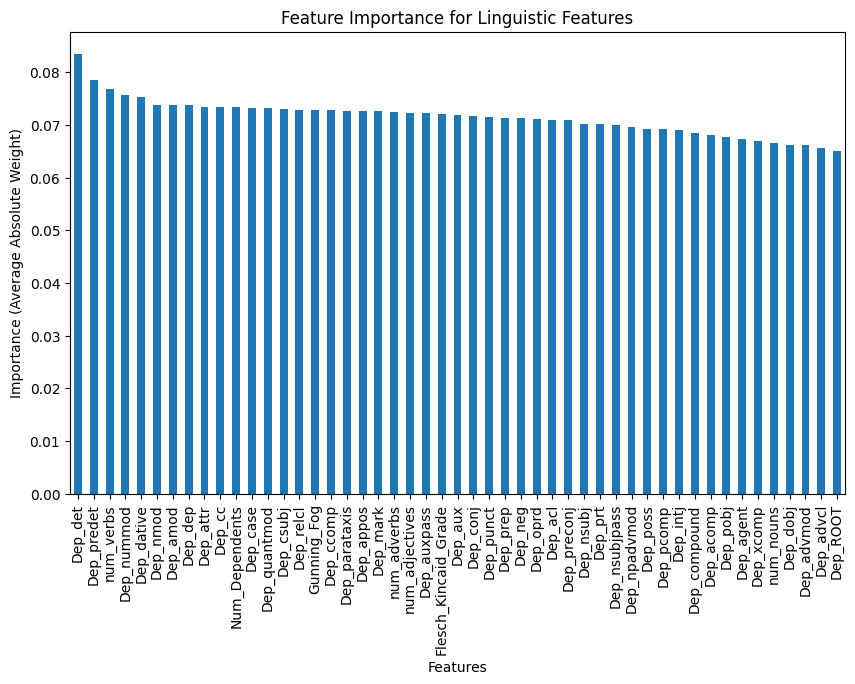

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.utils.data import Dataset
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Custom Dataset for Regression with additional features
class ParaphraseRegressionDataset(Dataset):
    def __init__(self, data, tokenizer, feature_columns):
        self.data = data
        self.tokenizer = tokenizer
        self.feature_columns = feature_columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]['Sentence']
        label = self.data.iloc[idx]['Total Paraphrases']
        additional_features = self.data.iloc[idx][self.feature_columns].values.astype(float)

        encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['features'] = torch.tensor(additional_features, dtype=torch.float)
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

# Custom BERT Model with additional layers for linguistic features
class BertRegressionWithFeatures(torch.nn.Module):
    def __init__(self, model_name, num_features, dropout_rate=0.1):
        super(BertRegressionWithFeatures, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)
        self.dropout_bert = torch.nn.Dropout(dropout_rate)
        self.feature_fc = torch.nn.Linear(num_features, 128)
        self.dropout_features = torch.nn.Dropout(dropout_rate)
        self.custom_fc = torch.nn.Linear(896, 1024)  # 768 from BERT + 128 from features
        self.hidden_fc = torch.nn.Linear(1024, 1024)
        self.output_fc = torch.nn.Linear(1024, 1)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, features=None, labels=None):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout_bert(pooled_output)

        feature_output = torch.relu(self.feature_fc(features))
        feature_output = self.dropout_features(feature_output)

        combined_output = torch.cat((pooled_output, feature_output), dim=1)

        custom_output = torch.relu(self.custom_fc(combined_output))
        hidden_output = torch.relu(self.hidden_fc(custom_output))

        logits = self.output_fc(hidden_output)

        loss = None
        if labels is not None:
            loss = torch.nn.functional.mse_loss(logits.view(-1), labels.view(-1))

        return {"loss": loss, "logits": logits}

# Load the dataset
file_path = 'Enriched_Dataset.xlsx'
data = pd.read_excel(file_path)

# Handle missing values (if any) and ensure data integrity
data = data.dropna(subset=['Sentence', 'Total Paraphrases'])

# Duplicate data to balance the dataset
duplicated_data = pd.concat([data, data], ignore_index=True)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Select the feature columns (excluding Sentence and Total Paraphrases)
feature_columns = list(data.columns)
feature_columns.remove('Sentence')
feature_columns.remove('Total Paraphrases')

# Ensure feature columns contain only numerical values
for col in feature_columns:
    duplicated_data[col] = pd.to_numeric(duplicated_data[col], errors='coerce')

# Drop rows with missing or invalid numerical values in feature columns
duplicated_data = duplicated_data.dropna(subset=feature_columns)

# Split data into training and validation sets
train_data, val_data = train_test_split(duplicated_data, test_size=0.1, random_state=42)
train_dataset = ParaphraseRegressionDataset(train_data, tokenizer, feature_columns)
val_dataset = ParaphraseRegressionDataset(val_data, tokenizer, feature_columns)

# Load modified BERT model
num_features = len(feature_columns)
model = BertRegressionWithFeatures('bert-base-uncased', num_features)

# Check for CUDA availability and move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store losses and scores over epochs
training_losses = []
validation_losses = []
r2_scores = []
mse_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    evaluation_strategy="epoch",  # Evaluate after every epoch
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
)

# Define compute_metrics function to track R2, MSE, precision, recall, and F1-score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze()

    # Convert predictions to binary using a threshold (example: 0.5)
    threshold = 0.5
    pred_labels = (preds >= threshold).astype(int)
    labels_binary = (labels >= threshold).astype(int)

    r2 = r2_score(labels, preds)
    mse = mean_squared_error(labels, preds)
    precision = precision_score(labels_binary, pred_labels, zero_division=0)
    recall = recall_score(labels_binary, pred_labels, zero_division=0)
    f1 = f1_score(labels_binary, pred_labels, zero_division=0)

    return {"r2": r2, "mse": mse, "precision": precision, "recall": recall, "f1": f1}

# Create a custom callback to capture loss and evaluation metrics after each epoch
class CustomCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Capture training loss
        training_losses.append(state.log_history[-1]['loss'])  # Get the last recorded loss

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Capture validation loss, R2, MSE, precision, recall, and F1
        validation_losses.append(metrics['eval_loss'])
        r2_scores.append(metrics['eval_r2'])
        mse_scores.append(metrics['eval_mse'])
        precision_scores.append(metrics['eval_precision'])
        recall_scores.append(metrics['eval_recall'])
        f1_scores.append(metrics['eval_f1'])

# Trainer with the custom callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # Track R2, MSE, precision, recall, and F1
    callbacks=[CustomCallback()],
)

# Train the model
trainer.train()

# Plot: Training and Validation Loss over Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot: R² Score vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(r2_scores) + 1), r2_scores, label='R² Score')
plt.title('R² Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()

# Plot: Mean Squared Error (MSE) over Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, label='MSE')
plt.title('Mean Squared Error over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plot: Precision, Recall, and F1-Score over Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(precision_scores) + 1), precision_scores, label='Precision', color='orange')
plt.plot(range(1, len(recall_scores) + 1), recall_scores, label='Recall', color='green')
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label='F1 Score', color='red')
plt.title('Precision, Recall, and F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

# Predict on the validation set
predictions = trainer.predict(val_dataset).predictions.squeeze()
true_values = val_dataset.data['Total Paraphrases'].values

# Plot: Predicted vs Actual Paraphrase Counts
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5)
plt.title('Predicted vs Actual Paraphrase Counts')
plt.xlabel('Actual Paraphrase Counts')
plt.ylabel('Predicted Paraphrase Counts')
plt.show()

# Feature Importance: Extract weights from the fully connected layer
def plot_feature_importance(model, feature_columns):
    # Extract weights between the input features and the neurons in feature_fc
    weights = model.feature_fc.weight.cpu().detach().numpy()

    # For each feature, we calculate the average absolute weight across all neurons
    feature_importance = np.mean(np.abs(weights), axis=0)

    # Create a pandas Series for feature importance
    feature_importance_series = pd.Series(feature_importance, index=feature_columns)
    feature_importance_series = feature_importance_series.sort_values(ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    feature_importance_series.plot(kind='bar')
    plt.title('Feature Importance for Linguistic Features')
    plt.xlabel('Features')
    plt.ylabel('Importance (Average Absolute Weight)')
    plt.show()

# Call the function to plot feature importance
plot_feature_importance(model, feature_columns)
